<a href="https://colab.research.google.com/github/melisamichuki01/Statististics-with-python/blob/main/Anomaly_Detection_Time_Series_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img align=center src="https://rhyme.com/assets/img/logo-dark.png"></img>
<h2 align=center>Introduction to Anomaly Detection in Time Series with Keras</h2>


## Task 1: Project Overview and Import Libraries

In [8]:
import numpy as np
import tensorflow as tf
import pandas as pd
pd.options.mode.chained_assignment = None
import seaborn as sns
from matplotlib.pylab import rcParams
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

%matplotlib inline

sns.set(style='whitegrid', palette='muted')
rcParams['figure.figsize'] = 14, 8
np.random.seed(1)
               
tf.random.set_seed(1)

print('Tensorflow version:', tf.__version__)

Tensorflow version: 2.5.0


## Task 2: Load and Inspect the S&P 500 Index Data

[Data Source](https://www.kaggle.com/pdquant/sp500-daily-19862018): S&P500 Daily Prices 1986 - 2018

In [9]:
df = pd.read_csv('/content/S&P_500_Index_Data.csv',parse_dates=['date'])
df.head()

,date,close
0,1986-01-02,209.59
1,1986-01-03,210.88
2,1986-01-06,210.65
3,1986-01-07,213.80
4,1986-01-08,207.97


In [10]:
df.shape

(8192, 2)

In [7]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df.date,y=df.close, mode='lines',name='close'))
fig.update_layout(showlegend=True)
fig.show()

## Task 3: Data Preprocessing

In [11]:
train_size = int(len(df)*0.8)
test_size = len(df) - train_size
train,test = df.iloc[0:train_size],df.iloc[train_size:len(df)]
print(train.shape,test.shape)

(6553, 2) (1639, 2)


In [12]:
from sklearn.preprocessing import StandardScaler

scaler =StandardScaler()
scaler = scaler.fit(train[['close']])

train['close'] = scaler.transform(train[['close']])
test['close'] =scaler.transform(test[['close']])

## Task 4: Create Training and Test Splits

In [13]:
def create_sequences(X,y,time_steps=1):
  Xs,ys = [],[]
  for i in range(len(X) - time_steps):
    Xs.append(X.iloc[i:(i + time_steps)].values)
    ys.append(y.iloc[i:(i + time_steps)])
  return np.array(Xs), np.array(ys)

In [14]:
time_steps=30

X_train, y_train = create_sequences(train[['close']], train.close, time_steps)
X_test, y_test = create_sequences(test[['close']], test.close, time_steps)

In [15]:
print(X_train.shape)

(6523, 30, 1)


## Task 5: Build an LSTM Autoencoder

In [16]:
timesteps = X_train.shape[1]
num_features = X_train.shape[2]

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed

model = Sequential([
        LSTM(128, input_shape=(timesteps,num_features)),
        Dropout(0.2),
        RepeatVector(timesteps),
        LSTM(128, return_sequences=True),
        Dropout(0.2),
        TimeDistributed(Dense(num_features))
])

model.compile(loss='mae',optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               66560     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 30, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 128)           131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 128)           0         
_________________________________________________________________
time_distributed (TimeDistri (None, 30, 1)             129       
Total params: 198,273
Trainable params: 198,273
Non-trainable params: 0
__________________________________________________

## Task 6: Train the Autoencoder

In [19]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3,mode='min')
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    callbacks = [es],
    shuffle = False #Order matters in time series
)

Epoch 1/100
184/184 [==============================] - 17s 75ms/step - loss: 0.1634 - val_loss: 0.0992
Epoch 2/100
184/184 [==============================] - 13s 72ms/step - loss: 0.0987 - val_loss: 0.1234
Epoch 3/100
184/184 [==============================] - 13s 71ms/step - loss: 0.0880 - val_loss: 0.1685
Epoch 4/100
184/184 [==============================] - 13s 71ms/step - loss: 0.0899 - val_loss: 0.0716
Epoch 5/100
184/184 [==============================] - 13s 71ms/step - loss: 0.1099 - val_loss: 0.0658
Epoch 6/100
184/184 [==============================] - 13s 71ms/step - loss: 0.1175 - val_loss: 0.0684
Epoch 7/100
184/184 [==============================] - 13s 71ms/step - loss: 0.1255 - val_loss: 0.0693
Epoch 8/100
184/184 [==============================] - 13s 71ms/step - loss: 0.1341 - val_loss: 0.0929


## Task 7: Plot Metrics and Evaluate the Model

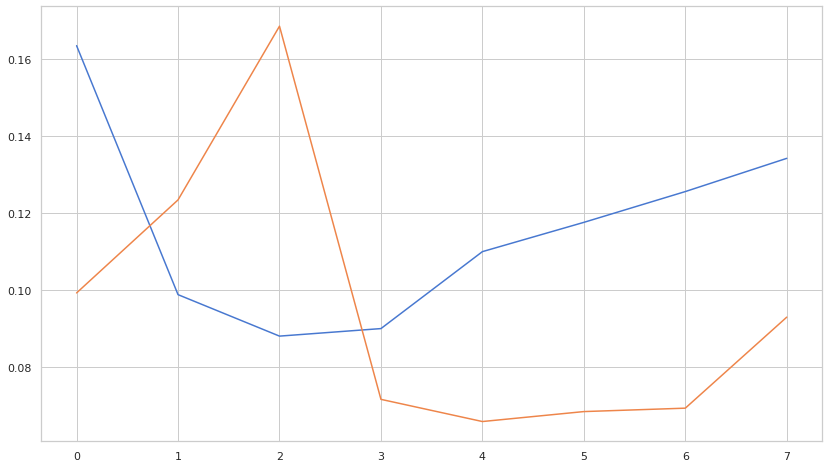

In [20]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')

In [22]:
X_train_pred = model.predict(X_train)

train_mae_loss = pd.DataFrame(np.mean(np.abs(X_train_pred - X_train),axis=1),columns=['Error'])

In [23]:
model.evaluate(X_test, y_test)

51/51 [==============================] - 1s 21ms/step - loss: 0.6484


0.6484124064445496

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



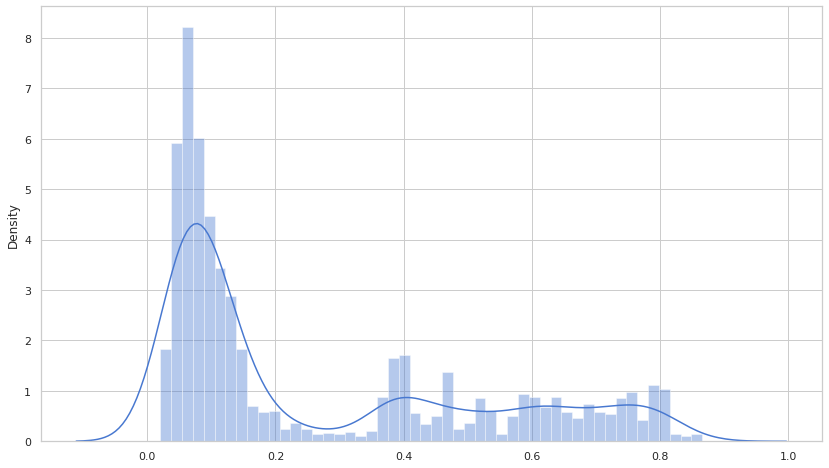

In [24]:
sns.distplot(train_mae_loss, bins=50,kde=True)

In [65]:
threshold =0.7

In [66]:
X_test_pred = model.predict(X_test)
test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis =1)

## Task 8: Detect Anomalies in the S&P 500 Index Data

In [67]:
test_score_df = pd.DataFrame(test[time_steps:])
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = threshold
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['close'] = test[time_steps:].close

In [68]:
test_score_df.head()

,date,close,loss,threshold,anomaly
6583,2012-02-08,1.216856,0.108474,0.7,False
6584,2012-02-09,1.221625,0.109216,0.7,False
6585,2012-02-10,1.199313,0.108759,0.7,False
6586,2012-02-13,1.221194,0.101285,0.7,False
6587,2012-02-14,1.218150,0.099129,0.7,False


In [69]:
test_score_df.tail()

,date,close,loss,threshold,anomaly
8187,2018-06-25,4.493228,1.985046,0.7,True
8188,2018-06-26,4.507583,1.992372,0.7,True
8189,2018-06-27,4.451431,1.995119,0.7,True
8190,2018-06-28,4.491406,1.999879,0.7,True
8191,2018-06-29,4.496343,1.998578,0.7,True


In [70]:
fig1 = go.Figure()
fig1.add_trace(go.Scatter(x=test[time_steps:].date, y=test_score_df.loss, mode='lines',name='Test Loss'))
fig1.add_trace(go.Scatter(x=test[time_steps:].date, y=test_score_df.threshold, mode='lines', name='Threshold'))
fig1.update_layout(showlegend=True)
fig1.show()

In [71]:
anomalies = test_score_df[test_score_df.anomaly == True]
anomalies.head()

,date,close,loss,threshold,anomaly
7414,2015-06-01,3.042489,0.703219,0.7,True
7415,2015-06-02,3.037385,0.706818,0.7,True
7416,2015-06-03,3.048097,0.708785,0.7,True
7417,2015-06-04,3.004408,0.709203,0.7,True
7418,2015-06-05,2.997194,0.713897,0.7,True


In [72]:
fig2 = go.Figure()
fig2.add_trace(go.Scatter(x=test[time_steps:].date, y=scaler.inverse_transform(test[time_steps:].close), mode='lines',name='Close price'))
fig2.add_trace(go.Scatter(x=anomalies.date, y=scaler.inverse_transform(anomalies.close), mode='markers', name='Anomaly'))
fig2.update_layout(showlegend=True)
fig2.show()